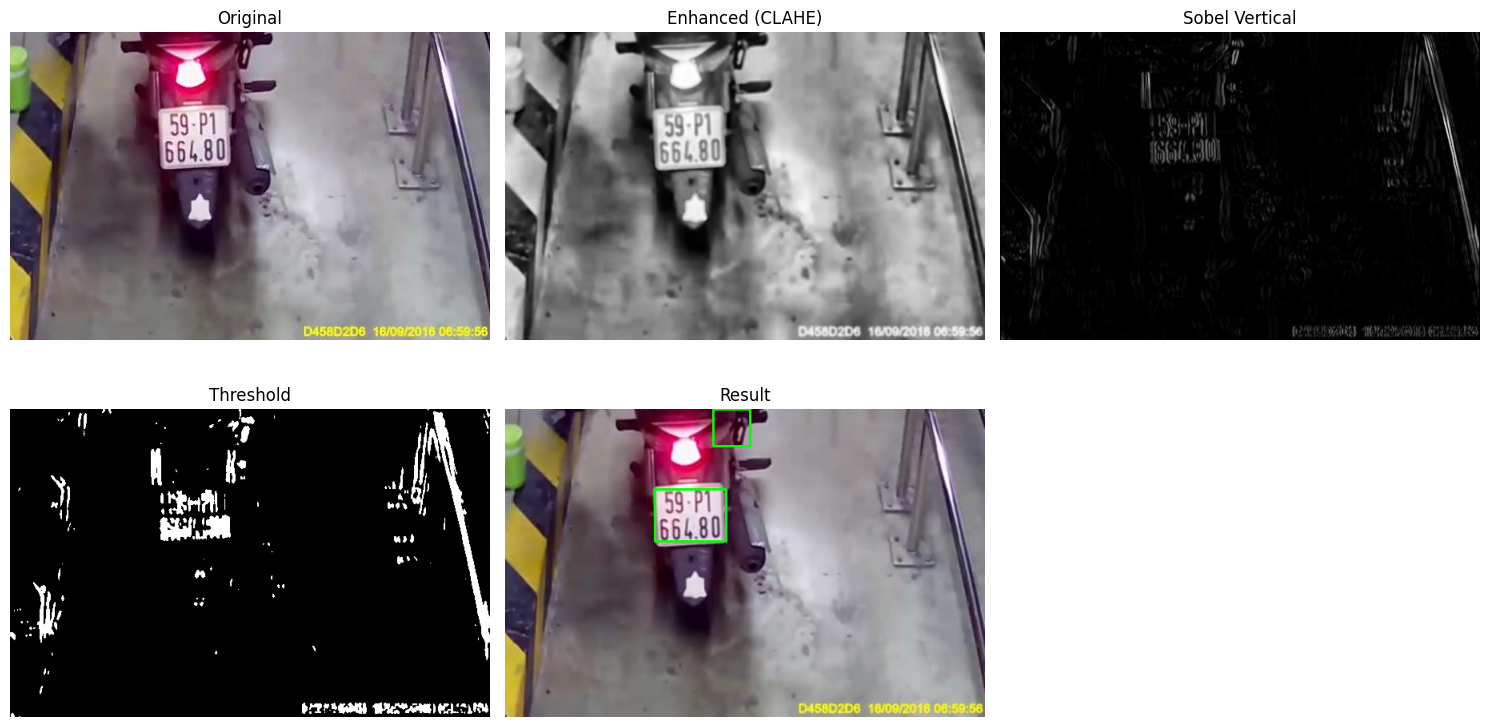

Tìm thấy 2 biển số.


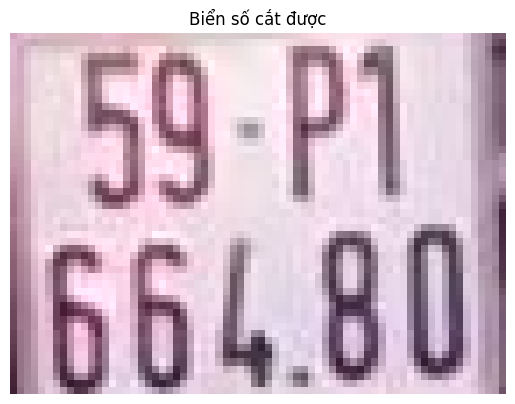

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_plate_advanced(img_path, debug=True):
    """
    Hệ thống phát hiện biển số nâng cao với tiền xử lý khử nhiễu và cân bằng sáng.
    Args:
        img_path: Đường dẫn ảnh đầu vào.
        debug: Nếu True, sẽ hiển thị các bước xử lý trung gian.
    """
    
    # 1. ĐỌC ẢNH & RESIZE
    img_original = cv2.imread(img_path)
    if img_original is None:
        print("Lỗi: Không tìm thấy file ảnh!")
        return []

    # Resize về chiều rộng 600px để chuẩn hóa kích thước xử lý
    target_width = 600
    scale = target_width / img_original.shape[1]
    h_new = int(img_original.shape[0] * scale)
    img = cv2.resize(img_original, (target_width, h_new))
    
    # --- BƯỚC NÂNG CẤP 1: TIỀN XỬ LÝ MẠNH MẼ ---
    
    # Chuyển xám
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # [NÂNG CẤP] Khử nhiễu Gaussian
    # Kích thước (5,5) giúp làm mịn nhiễu hạt nhưng không làm mờ quá nhiều biên
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # [NÂNG CẤP] Cân bằng Histogram thích nghi (CLAHE)
    # ClipLimit=2.0: Ngưỡng hạn chế độ tương phản (tránh khuếch đại nhiễu)
    # TileGridSize=(8,8): Chia ảnh thành lưới 8x8 để cân bằng cục bộ
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    
    # --- BƯỚC 2: LÀM NỔI BẬT & DÒ BIÊN ---
    
    # TopHat: Làm nổi bật chi tiết sáng (biển số) trên nền tối
    # Dùng kernel chữ nhật vì biển số hình chữ nhật
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, rectKern)
    
    # Sobel dọc: Chỉ bắt các cạnh thẳng đứng (đặc trưng của ký tự trên biển)
    sobelx = cv2.Sobel(tophat, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    
    # Chuẩn hóa về 0-255
    min_val, max_val = np.min(sobelx), np.max(sobelx)
    sobelx = (255 * ((sobelx - min_val) / (max_val - min_val))).astype("uint8")
    
    # Otsu Thresholding: Tự động tìm ngưỡng nhị phân
    # Thêm Gaussian Blur lần nữa trước khi threshold để đường biên mượt hơn
    sobelx_blurred = cv2.GaussianBlur(sobelx, (5, 5), 0)
    _, thresh = cv2.threshold(sobelx_blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # --- BƯỚC 3: CHIẾN LƯỢC MULTI-KERNEL ---
    
    # Dùng phép Đóng (Close) để nối các nét đứt của ký tự thành 1 khối (blob)
    # Thử 2 kernel phổ biến nhất cho xe máy và oto tại VN
    kernels = [(17, 5), (17, 12)] 
    candidates = []
    
    for k_size in kernels:
        morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, k_size)
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, morph_kernel)
        
        # Tìm contour
        cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in cnts:
            # Lấy hình chữ nhật bao quanh (Bounding Rect)
            x, y, w, h = cv2.boundingRect(c)
            ar = w / float(h)
            
            # Lọc theo kích thước và tỷ lệ (Aspect Ratio)
            # Biển VN: Xe máy (~1.2 - 1.5), Oto dài (~4.0 - 5.5)
            if w > 30 and h > 15 and 1.0 <= ar <= 6.0:
                candidates.append((x, y, w, h, closed[y:y+h, x:x+w]))

    # --- BƯỚC 4: CHẤM ĐIỂM & CHỌN LỌC (Post-Processing) ---
    
    final_plates = []
    merged_mask = np.zeros(gray.shape, dtype="uint8")
    
    # Sắp xếp candidate theo diện tích (lớn ưu tiên trước)
    candidates = sorted(candidates, key=lambda x: x[2]*x[3], reverse=True)
    
    for (x, y, w, h, roi_mask) in candidates:
        # Nếu vùng này chưa bị đè bởi vùng khác tốt hơn
        if merged_mask[y:y+h, x:x+w].mean() == 0:
            
            # Tính mật độ điểm trắng (Edge Density)
            # Biển số thật là vùng tập trung nhiều cạnh (chữ/số)
            white_pixels = cv2.countNonZero(roi_mask)
            density = white_pixels / (w * h)
            
            # Ngưỡng mật độ: 0.25 đến 0.75 (Nới lỏng hơn version trước một chút)
            if 0.25 < density < 0.75:
                # Vẽ khung lên ảnh gốc (đã resize)
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
                # Cắt ảnh biển số từ ảnh gốc (chất lượng cao nhất)
                # Tính tọa độ trên ảnh gốc ban đầu
                real_y1 = int(y / scale)
                real_y2 = int((y+h) / scale)
                real_x1 = int(x / scale)
                real_x2 = int((x+w) / scale)
                
                plate_crop = img_original[real_y1:real_y2, real_x1:real_x2]
                final_plates.append(plate_crop)
                
                # Đánh dấu vùng này đã xử lý
                merged_mask[y:y+h, x:x+w] = 255

    # --- HIỂN THỊ DEBUG (CHO BÁO CÁO) ---
    if debug:
        titles = ['Original', 'Enhanced (CLAHE)', 'Sobel Vertical', 'Threshold', 'Result']
        images = [
            cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB),
            enhanced,
            sobelx,
            thresh,
            cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ]
        
        plt.figure(figsize=(15, 8))
        for i in range(5):
            plt.subplot(2, 3, i+1)
            if len(images[i].shape) == 2: # Nếu là ảnh xám
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    return final_plates

# --- CHẠY THỬ ---
# Thay 'test_car.jpg' bằng ảnh của bạn
found_plates = detect_plate_advanced('0000_00532_b.jpg', debug=True)

print(f"Tìm thấy {len(found_plates)} biển số.")
if len(found_plates) > 0:
    # Hiển thị biển số đầu tiên tìm được
    plt.imshow(cv2.cvtColor(found_plates[0], cv2.COLOR_BGR2RGB))
    plt.title("Biển số cắt được")
    plt.axis('off')
    plt.show()

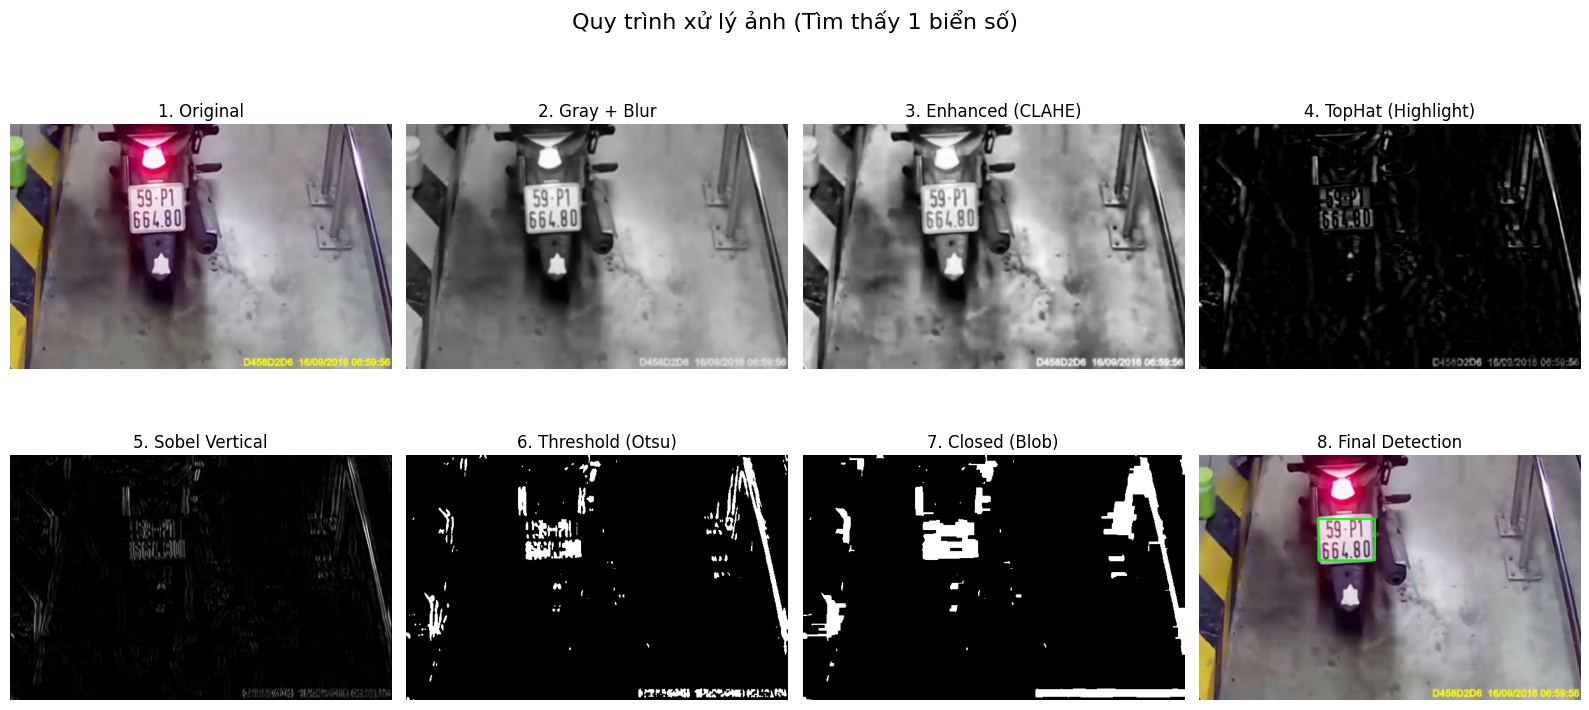

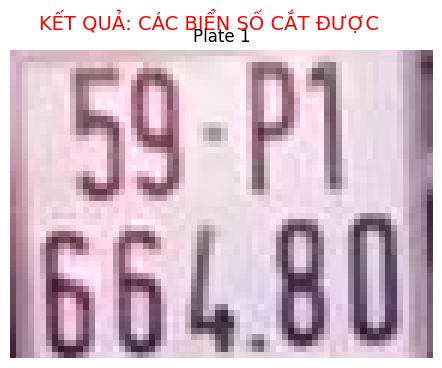

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_processing_steps(img_path):
    # --- PHẦN 1: XỬ LÝ ẢNH (PROCESSING) ---
    
    # 1. Đọc ảnh
    img_original = cv2.imread(img_path)
    if img_original is None:
        print("Lỗi: Không đọc được ảnh!")
        return

    # Resize để chuẩn hóa
    target_width = 600
    scale = target_width / img_original.shape[1]
    h_new = int(img_original.shape[0] * scale)
    img = cv2.resize(img_original, (target_width, h_new))
    img_display = img.copy() # Dùng để vẽ khung chữ nhật sau này

    # 2. Tiền xử lý (Gray -> Blur -> CLAHE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    # 3. Làm nổi bật & Dò biên
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, rectKern)

    sobelx = cv2.Sobel(tophat, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    min_val, max_val = np.min(sobelx), np.max(sobelx)
    sobelx = (255 * ((sobelx - min_val) / (max_val - min_val))).astype("uint8")

    # 4. Nhị phân hóa (Threshold)
    sobelx_blurred = cv2.GaussianBlur(sobelx, (5, 5), 0)
    _, thresh = cv2.threshold(sobelx_blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # 5. Đóng khối (Morphology Close) - Lấy ví dụ kernel chuẩn (17, 5) để hiển thị
    morph_kernel_display = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 5))
    closed_display = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, morph_kernel_display)

    # --- PHẦN 2: TÌM & CẮT BIỂN SỐ (DETECTION) ---
    kernels = [(17, 5), (17, 12), (10, 5)] # Các kernel khác nhau
    candidates = []

    for k_size in kernels:
        morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, k_size)
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, morph_kernel)
        cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            ar = w / float(h)
            if w > 30 and h > 15 and 1.2 <= ar <= 6.0:
                candidates.append((x, y, w, h, closed[y:y+h, x:x+w]))

    # Lọc trùng và cắt ảnh
    final_plates = []
    merged_mask = np.zeros(gray.shape, dtype="uint8")
    candidates = sorted(candidates, key=lambda x: x[2]*x[3], reverse=True)

    for (x, y, w, h, roi_mask) in candidates:
        if merged_mask[y:y+h, x:x+w].mean() == 0:
            density = cv2.countNonZero(roi_mask) / (w * h)
            if 0.25 < density < 0.75:
                # Vẽ khung xanh lên ảnh hiển thị
                cv2.rectangle(img_display, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
                # Cắt ảnh từ ảnh GỐC (chất lượng cao nhất)
                real_y1, real_y2 = int(y/scale), int((y+h)/scale)
                real_x1, real_x2 = int(x/scale), int((x+w)/scale)
                final_plates.append(img_original[real_y1:real_y2, real_x1:real_x2])
                
                merged_mask[y:y+h, x:x+w] = 255

    # --- PHẦN 3: HIỂN THỊ TỪNG BƯỚC (VISUALIZATION) ---
    
    # Tạo danh sách các ảnh cần show
    steps = [
        ("1. Original", cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),
        ("2. Gray + Blur", blurred),
        ("3. Enhanced (CLAHE)", enhanced),
        ("4. TopHat (Highlight)", tophat),
        ("5. Sobel Vertical", sobelx),
        ("6. Threshold (Otsu)", thresh),
        ("7. Closed (Blob)", closed_display),
        ("8. Final Detection", cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    ]

    # Vẽ Bảng 1: Các bước xử lý
    plt.figure(figsize=(16, 8))
    plt.suptitle(f"Quy trình xử lý ảnh (Tìm thấy {len(final_plates)} biển số)", fontsize=16)
    
    for i, (title, image) in enumerate(steps):
        plt.subplot(2, 4, i+1)
        if len(image.shape) == 2: # Ảnh xám
            plt.imshow(image, cmap='gray')
        else: # Ảnh màu
            plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Vẽ Bảng 2: Tất cả biển số cắt được
    if len(final_plates) > 0:
        plt.figure(figsize=(10, 4))
        plt.suptitle("KẾT QUẢ: CÁC BIỂN SỐ CẮT ĐƯỢC", fontsize=14, color='red')
        
        num_plates = len(final_plates)
        for i, plate in enumerate(final_plates):
            plt.subplot(1, num_plates, i+1) # Tự động chia cột theo số lượng biển
            plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
            plt.title(f"Plate {i+1}")
            plt.axis('off')
        plt.show()
    else:
        print("KHÔNG TÌM THẤY BIỂN SỐ NÀO!")

# --- CHẠY THỬ ---
visualize_processing_steps('0000_00532_b.jpg')

Đang xử lý 2 biển số...


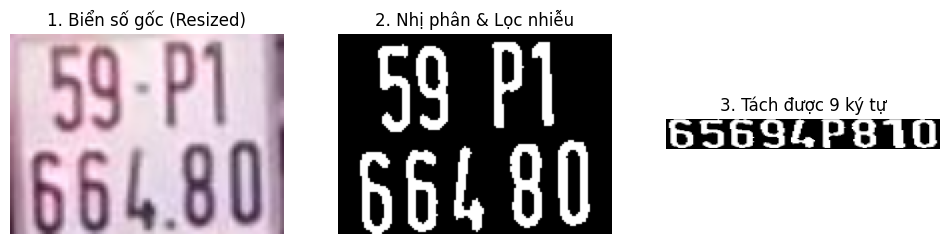

Biển số 1: Tìm thấy 9 ký tự ứng viên.


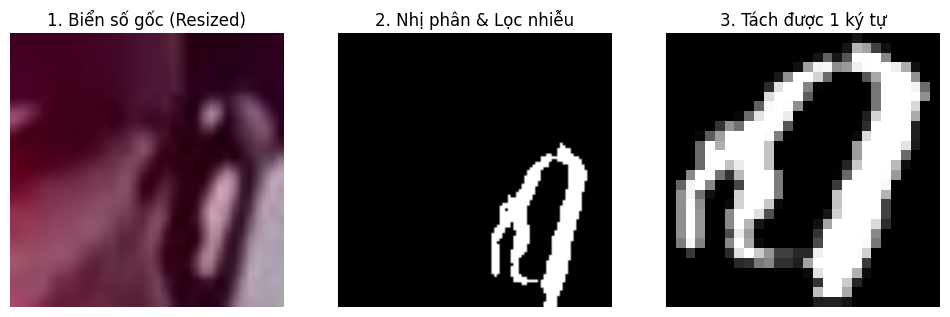

Biển số 2: Tìm thấy 1 ký tự ứng viên.


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    # Sắp xếp 4 điểm theo thứ tự: trên-trái, trên-phải, dưới-phải, dưới-trái
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def perspective_transform(image, pts):
    # Hàm nắn chỉnh hình học (Warp Perspective) dựa trên 4 điểm góc
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Tính chiều rộng và cao mới của ảnh sau khi nắn
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def process_and_segment(plate_img):
    """
    Nhận vào ảnh cắt biển số (plate_img), thực hiện xoay thẳng và tách ký tự.
    """
    # 1. TIỀN XỬ LÝ LẠI TRÊN ẢNH BIỂN SỐ
    # Resize to lên chút để dễ xử lý (Chiều cao cố định 100px)
    scale = 100 / plate_img.shape[0]
    w_new = int(plate_img.shape[1] * scale)
    plate_img = cv2.resize(plate_img, (w_new, 100))
    
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    
    # Nhị phân hóa (Dùng Adaptive Threshold để chống lóa/bóng râm cục bộ)
    # BlockSize=11, C=2 là tham số chuẩn cho văn bản
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 19, 9)

    # 2. LỌC NHIỄU BIÊN (BORDER CLEANING)
    # Các cạnh biển số thường bị dính viền đen/trắng, cần loại bỏ
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Tạo mask để xóa các nhiễu nhỏ hoặc viền quá dài
    mask = np.zeros_like(binary)
    
    char_candidates = []
    
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h / w
        area = w * h
        # Điều kiện lọc KÝ TỰ:
        # - Chiều cao phải đủ lớn (>40% chiều cao biển)
        # - Tỷ lệ h/w hợp lý (chữ thường cao hơn rộng, ratio > 1.0)
        # - Diện tích không quá nhỏ
        if h > plate_img.shape[0] * 0.35 and 1.0 < ratio < 4.5 and area > 100:
             char_candidates.append((x, y, w, h, binary[y:y+h, x:x+w]))
             cv2.drawContours(mask, [c], -1, 255, -1) # Giữ lại vùng này trên mask

    # Áp dụng mask để lấy ảnh sạch
    clean_binary = cv2.bitwise_and(binary, binary, mask=mask)

    # 3. SẮP XẾP KÝ TỰ TỪ TRÁI SANG PHẢI
    # Rất quan trọng! Nếu không sắp xếp, biển số sẽ bị loạn (VD: 30A -> A03)
    char_candidates = sorted(char_candidates, key=lambda x: x[0])
    
    final_chars = []
    
    # Cắt từng ký tự ra để chuẩn bị cho bước nhận dạng
    for (x, y, w, h, char_roi) in char_candidates:
        # Resize về kích thước chuẩn của Model Training (VD: 20x40 hoặc 32x32)
        # Ở đây ta giữ nguyên tỷ lệ, chèn thêm viền đen để vuông vức
        roi = clean_binary[y:y+h, x:x+w]
        
        # Thêm viền đen (padding) để ký tự nằm giữa, không bị dính mép
        roi = cv2.copyMakeBorder(roi, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0)
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA) # Ví dụ resize về 28x28
        
        final_chars.append(roi)

    return plate_img, clean_binary, final_chars

# --- CODE CHẠY THỬ (Kết hợp với kết quả bước trước) ---
# Giả sử 'found_plates' là list chứa các ảnh biển số từ bước 1
# found_plates = detect_plate_advanced('0000_00532_b.jpg', debug=False)

if 'found_plates' in locals() and len(found_plates) > 0:
    print(f"Đang xử lý {len(found_plates)} biển số...")
    
    for i, plate in enumerate(found_plates):
        try:
            # Gọi hàm xử lý
            original_plate, processed_binary, characters = process_and_segment(plate)
            
            # --- HIỂN THỊ KẾT QUẢ ---
            plt.figure(figsize=(12, 4))
            
            # Ảnh gốc biển số
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(original_plate, cv2.COLOR_BGR2RGB))
            plt.title("1. Biển số gốc (Resized)")
            plt.axis('off')
            
            # Ảnh nhị phân đã lọc nhiễu
            plt.subplot(1, 3, 2)
            plt.imshow(processed_binary, cmap='gray')
            plt.title("2. Nhị phân & Lọc nhiễu")
            plt.axis('off')
            
            # Các ký tự cắt được
            plt.subplot(1, 3, 3)
            # Ghép các ký tự lại thành 1 hàng để hiển thị cho đẹp
            if len(characters) > 0:
                montage = np.hstack(characters) 
                plt.imshow(montage, cmap='gray')
                plt.title(f"3. Tách được {len(characters)} ký tự")
            else:
                plt.text(0.5, 0.5, "Không tách được ký tự", ha='center')
            
            plt.axis('off')
            plt.show()
            
            print(f"Biển số {i+1}: Tìm thấy {len(characters)} ký tự ứng viên.")
            
        except Exception as e:
            print(f"Lỗi khi xử lý biển số {i+1}: {str(e)}")
else:
    print("Bạn cần chạy bước 1 (detect_plate_advanced) để có biến found_plates trước!")

In [33]:
import cv2
import numpy as np
import os
import time

# --- IMPORT CÁC HÀM CŨ CỦA BẠN (Giả sử bạn để chung 1 file hoặc import từ module) ---
# Nếu bạn để code cũ ở file khác, hãy import. Ở đây tôi giả lập lại logic xử lý
#from my_plate_project import detect_plate_advanced, process_and_segment 

# CẤU HÌNH
RAW_IMAGES_DIR = 'raw_images' # Thư mục chứa ảnh xe gốc (bạn cần tạo và bỏ ảnh vào đây)
DATASET_DIR = 'dataset'          # Thư mục sẽ chứa dữ liệu train
MIN_SAMPLES = 20                 # Mục tiêu: mỗi ký tự cần ít nhất 20 mẫu

# Tạo các thư mục 0-9 và A-Z tự động
chars = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]
for char in chars:
    path = os.path.join(DATASET_DIR, char)
    if not os.path.exists(path):
        os.makedirs(path)

def save_character(img_char, key_pressed):
    """Lưu ảnh ký tự vào đúng thư mục dựa trên phím bấm"""
    label = None
    
    # Kiểm tra phím bấm là số hay chữ
    if 48 <= key_pressed <= 57: # Số 0-9
        label = chr(key_pressed)
    elif 65 <= key_pressed <= 90: # Chữ hoa A-Z
        label = chr(key_pressed)
    elif 97 <= key_pressed <= 122: # Chữ thường a-z -> convert sang hoa
        label = chr(key_pressed).upper()
    
    if label:
        save_path = os.path.join(DATASET_DIR, label)
        # Tạo tên file không trùng: timestamp.jpg
        filename = f"{int(time.time() * 1000)}.jpg"
        cv2.imwrite(os.path.join(save_path, filename), img_char)
        print(f"-> Đã lưu vào {label}/")
        return True
    return False

def main():
    # Lấy danh sách ảnh trong thư mục input
    files = [f for f in os.listdir(RAW_IMAGES_DIR) if f.endswith(('.jpg', '.png'))]
    print(f"Tìm thấy {len(files)} ảnh đầu vào.")
    print("HƯỚNG DẪN: Nhấn phím ký tự tương ứng để lưu. Nhấn SPACE để bỏ qua. Nhấn ESC để thoát.")

    for file_name in files:
        img_path = os.path.join(RAW_IMAGES_DIR, file_name)
        print(f"\nĐang xử lý: {file_name}...")
        
        # 1. Phát hiện biển số
        plates = detect_plate_advanced(img_path, debug=False)
        
        for plate in plates:
            # 2. Tách ký tự
            _, _, characters = process_and_segment(plate)
            
            # 3. Duyệt từng ký tự để người dùng gán nhãn
            for char_img in characters:
                # Resize to lên để dễ nhìn
                display_img = cv2.resize(char_img, (200, 200), interpolation=cv2.INTER_NEAREST)
                cv2.imshow("Data Labeling Tool", display_img)
                
                # Chờ bấm phím
                key = cv2.waitKey(0)
                
                if key == 27: # ESC
                    print("Đã thoát.")
                    return
                elif key == 32: # SPACE
                    print("-> Bỏ qua")
                    continue
                else:
                    save_character(char_img, key)

    cv2.destroyAllWindows()
    print("Hoàn tất thu thập dữ liệu!")

if __name__ == "__main__":
    main()

Tìm thấy 100 ảnh đầu vào.
HƯỚNG DẪN: Nhấn phím ký tự tương ứng để lưu. Nhấn SPACE để bỏ qua. Nhấn ESC để thoát.

Đang xử lý: 0509_01945_b.jpg...
-> Bỏ qua
-> Bỏ qua
-> Bỏ qua

Đang xử lý: 0509_04070_b.jpg...
-> Bỏ qua
-> Bỏ qua
-> Bỏ qua
-> Bỏ qua
-> Bỏ qua
-> Bỏ qua
-> Đã lưu vào 5/
-> Đã lưu vào 4/
-> Đã lưu vào 9/
-> Đã lưu vào 5/
-> Đã lưu vào U/
-> Đã lưu vào 7/
-> Đã lưu vào 2/

Đang xử lý: 0509_04094_b.jpg...
-> Bỏ qua
-> Bỏ qua

Đang xử lý: 0509_05645_b.jpg...
-> Bỏ qua
-> Bỏ qua
-> Bỏ qua

Đang xử lý: 0510_05493_b.jpg...
-> Bỏ qua
-> Đã lưu vào 0/
-> Đã lưu vào 3/
-> Bỏ qua
-> Đã lưu vào 5/
-> Đã lưu vào 3/
-> Đã lưu vào H/
-> Đã lưu vào 8/
-> Đã lưu vào 4/
-> Bỏ qua
-> Bỏ qua
-> Bỏ qua
-> Bỏ qua

Đang xử lý: 0510_05717_b.jpg...
-> Bỏ qua
-> Đã lưu vào 5/
-> Đã lưu vào 1/
-> Đã lưu vào 9/
-> Đã lưu vào 5/
-> Đã lưu vào G/
-> Đã lưu vào 9/
-> Đã lưu vào 1/
-> Đã lưu vào 0/
-> Bỏ qua
-> Bỏ qua

Đang xử lý: 0510_06059_b.jpg...
-> Bỏ qua

Đang xử lý: 0510_06621_b.jpg...
-> Bỏ qua


In [34]:
# train_knn.py
import cv2
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

DATASET_DIR = 'dataset'
IMG_SIZE = (20, 30) # Rộng 20, Cao 30 (Phù hợp với tỷ lệ chữ biển số)

print("Đang tải dữ liệu...")
data = []
labels = []

# Duyệt qua các folder 0-9, A-Z
for label in os.listdir(DATASET_DIR):
    path = os.path.join(DATASET_DIR, label)
    if not os.path.isdir(path): continue
    
    # Lấy danh sách ảnh trong folder
    for file in os.listdir(path):
        try:
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path, 0) # Đọc ảnh xám
            
            # Tiền xử lý quan trọng: Phải giống hệt lúc Segment
            img = cv2.resize(img, IMG_SIZE)
            
            # Flatten: Biến ảnh 20x30 thành vector 600 chiều
            feature = img.flatten()
            
            data.append(feature)
            labels.append(label)
        except:
            continue

data = np.array(data)
labels = np.array(labels)

print(f"Tổng số mẫu: {len(data)}")
print(f"Số lớp (Class): {len(np.unique(labels))}")

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Huấn luyện KNN
# k=1 hoặc k=3 thường tốt nhất cho OCR đơn giản
print("Đang training KNN...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Đánh giá
acc = knn.score(X_test, y_test)
print(f"Độ chính xác trên tập Test: {acc*100:.2f}%")

# Lưu model
joblib.dump(knn, 'knn_plate_model.pkl')
print("Đã lưu model thành công!")

Đang tải dữ liệu...
Tổng số mẫu: 817
Số lớp (Class): 26
Đang training KNN...
Độ chính xác trên tập Test: 96.95%
Đã lưu model thành công!


In [35]:
def recognize_plate_text(characters_images, model_path='knn_plate_model.pkl'):
    # Load model (chỉ load 1 lần, nên để biến này global hoặc load từ ngoài hàm)
    model = joblib.load(model_path)
    
    plate_text = ""
    for char_img in characters_images:
        # Resize về đúng kích thước lúc train (20x30)
        roi = cv2.resize(char_img, (20, 30), interpolation=cv2.INTER_AREA)
        
        # Flatten
        feature = roi.flatten().reshape(1, -1)
        
        # Dự đoán
        char = model.predict(feature)[0]
        plate_text += char
        
    return plate_text

--- AUTOMATIC LICENSE PLATE RECOGNITION (ALPR) ---
1. Đang tìm biển số...
2. Đang tách ký tự...
3. Đang đọc chữ...

>> KẾT QUẢ: 06353H84 <<


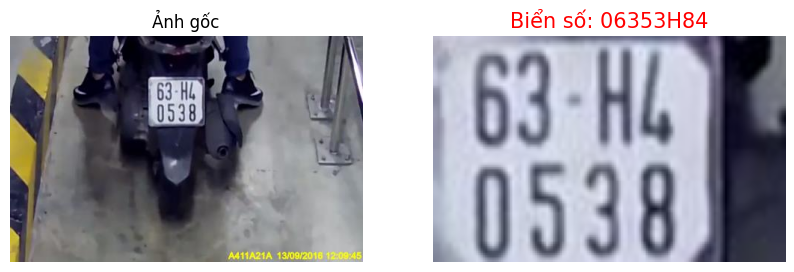

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib

# --- CẤU HÌNH ---
IMG_PATH = 'raw_images/0510_05493_b.jpg'  # Đổi thành ảnh bạn muốn test
MODEL_PATH = 'knn_plate_model.pkl'

# ==========================================
# 1. PHẦN DETECTION (Phát hiện biển số)
# ==========================================
def detect_plate(img):
    # Resize
    target_width = 600
    scale = target_width / img.shape[1]
    h_new = int(img.shape[0] * scale)
    img_resized = cv2.resize(img, (target_width, h_new))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Xử lý ảnh (Blur + CLAHE + Sobel + Otsu)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, rectKern)
    
    sobelx = cv2.Sobel(tophat, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = (255 * (sobelx / np.max(sobelx))).astype("uint8")
    
    sobelx_blurred = cv2.GaussianBlur(sobelx, (5, 5), 0)
    _, thresh = cv2.threshold(sobelx_blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Tìm contour
    kernels = [(17, 5), (17, 12)]
    candidates = []
    for k in kernels:
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, k))
        cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            ar = w / float(h)
            if w > 30 and h > 15 and 1.2 <= ar <= 6.0:
                candidates.append((x, y, w, h))

    # Chọn vùng tốt nhất (dựa trên vị trí và mật độ)
    candidates = sorted(candidates, key=lambda b: b[2]*b[3], reverse=True)
    if not candidates: return None

    # Lấy candidate to nhất (đơn giản hóa cho demo)
    x, y, w, h = candidates[0]
    
    # Cắt từ ảnh gốc (Map tọa độ ngược lại)
    real_x = int(x / scale)
    real_y = int(y / scale)
    real_w = int(w / scale)
    real_h = int(h / scale)
    
    return img[real_y:real_y+real_h, real_x:real_x+real_w]

# ==========================================
# 2. PHẦN SEGMENTATION (Tách ký tự)
# ==========================================
def segment_characters(plate_img):
    # Pre-process biển số
    scale = 100 / plate_img.shape[0]
    w_new = int(plate_img.shape[1] * scale)
    plate_img = cv2.resize(plate_img, (w_new, 100))
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)

    # Lọc nhiễu & Tách ký tự
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    char_list = []
    
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        ratio = h / w
        if h > plate_img.shape[0] * 0.35 and 1.0 < ratio < 4.5:
             # Cắt ký tự
             roi = binary[y:y+h, x:x+w]
             # Thêm viền
             roi = cv2.copyMakeBorder(roi, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0)
             # Resize về chuẩn 20x30 (giống lúc train)
             roi = cv2.resize(roi, (20, 30), interpolation=cv2.INTER_AREA)
             char_list.append((x, roi))

    # Sắp xếp từ trái sang phải
    char_list.sort(key=lambda x: x[0])
    return [c[1] for c in char_list], plate_img

# ==========================================
# 3. PHẦN RECOGNITION (Nhận dạng)
# ==========================================
def predict_text(chars, model_path):
    try:
        model = joblib.load(model_path)
    except:
        return "ERR_MODEL"
        
    text = ""
    for char_img in chars:
        # Flatten ảnh 20x30 -> vector 600
        feature = char_img.flatten().reshape(1, -1)
        pred = model.predict(feature)[0]
        text += pred
    return text

# Hàm sửa lỗi logic (Heuristic)
def post_process(text):
    if len(text) < 5: return text
    res = list(text)
    
    # Ký tự thứ 3 thường là CHỮ (VD: 29A...)
    # Nếu nhận là số 4 -> sửa thành A
    # Nếu nhận là số 8 -> sửa thành B
    if len(res) > 2:
        if res[2] == '4': res[2] = 'A'
        if res[2] == '8': res[2] = 'B'
        if res[2] == '0': res[2] = 'D'
    
    # Các ký tự cuối thường là SỐ
    # Nếu nhận là B -> sửa thành 8
    if len(res) > 4:
        for i in range(3, len(res)):
            if res[i] == 'B': res[i] = '8'
            if res[i] == 'S': res[i] = '5'
            if res[i] == 'O': res[i] = '0' # Chữ O và số 0
            
    return "".join(res)

# ==========================================
# MAIN FUNCTION
# ==========================================
if __name__ == "__main__":
    print("--- AUTOMATIC LICENSE PLATE RECOGNITION (ALPR) ---")
    
    # 1. Đọc ảnh
    img_origin = cv2.imread(IMG_PATH)
    if img_origin is None:
        print(f"Lỗi: Không tìm thấy ảnh {IMG_PATH}")
        exit()

    # 2. Phát hiện biển
    print("1. Đang tìm biển số...")
    plate = detect_plate(img_origin)
    
    if plate is None:
        print("Không tìm thấy biển số!")
    else:
        # 3. Tách ký tự
        print("2. Đang tách ký tự...")
        chars, plate_display = segment_characters(plate)
        
        # 4. Nhận dạng
        print("3. Đang đọc chữ...")
        if len(chars) == 0:
            print("Không tách được ký tự nào!")
        else:
            raw_text = predict_text(chars, MODEL_PATH)
            final_text = post_process(raw_text)
            
            print(f"\n>> KẾT QUẢ: {final_text} <<")
            
            # 5. Hiển thị
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
            plt.title("Ảnh gốc")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(plate_display, cv2.COLOR_BGR2RGB))
            plt.title(f"Biển số: {final_text}", fontsize=15, color='red')
            plt.axis('off')
            
            plt.show()

--- ALPR SYSTEM ---
1. Đang phát hiện biển số...
2. Đang tách và sắp xếp ký tự...
3. Đang nhận dạng...

>> TEXT GỐC: 1184900
>> TEXT XỬ LÝ: 11B4900


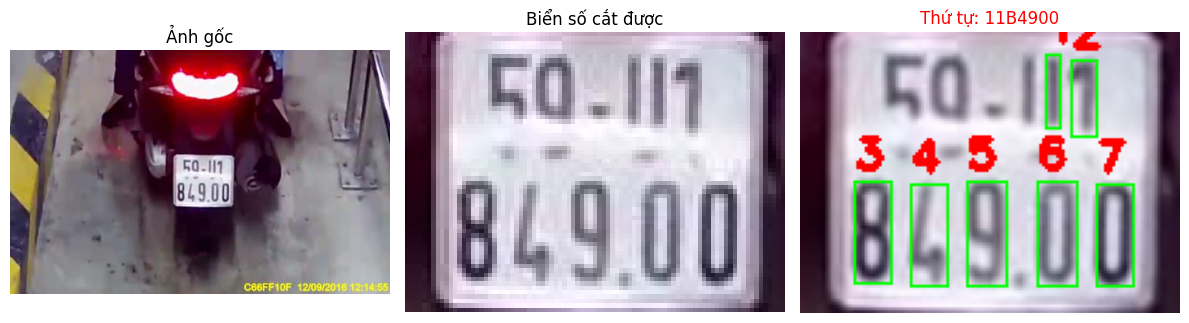

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# --- CẤU HÌNH ---
IMG_PATH = 'raw_images/0515_07185_b.jpg'  # Đổi thành đường dẫn ảnh của bạn
MODEL_PATH = 'knn_plate_model.pkl'

# ==========================================
# 1. PHẦN DETECTION (Phát hiện biển số)
# ==========================================
def detect_plate(img):
    # Resize ảnh để xử lý nhanh
    target_width = 600
    scale = target_width / img.shape[1]
    h_new = int(img.shape[0] * scale)
    img_resized = cv2.resize(img, (target_width, h_new))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Tiền xử lý: Blur -> CLAHE -> Morph -> Sobel -> Threshold
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    
    # TopHat làm nổi bật chi tiết sáng trên nền tối
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, rectKern)
    
    # Sobel dọc
    sobelx = cv2.Sobel(tophat, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = (255 * (sobelx / np.max(sobelx))).astype("uint8")
    
    # Đóng khoảng hở
    sobelx_blurred = cv2.GaussianBlur(sobelx, (5, 5), 0)
    _, thresh = cv2.threshold(sobelx_blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Tìm contour
    kernels = [(17, 5), (17, 12)]
    candidates = []
    
    for k in kernels:
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, k))
        cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            ar = w / float(h)
            if w > 30 and h > 15 and 1.2 <= ar <= 6.0:
                candidates.append((x, y, w, h))

    candidates = sorted(candidates, key=lambda b: b[2]*b[3], reverse=True)
    if not candidates: return None

    x, y, w, h = candidates[0]
    
    # Cắt từ ảnh gốc
    real_x = int(x / scale)
    real_y = int(y / scale)
    real_w = int(w / scale)
    real_h = int(h / scale)
    
    # Padding nhẹ
    pad = 5
    img_h, img_w = img.shape[:2]
    real_y = max(0, real_y - pad); real_x = max(0, real_x - pad)
    real_h = min(img_h - real_y, real_h + 2*pad); real_w = min(img_w - real_x, real_w + 2*pad)
    
    return img[real_y:real_y+real_h, real_x:real_x+real_w]

# ==========================================
# 2. PHẦN SEGMENTATION (Tách & Sắp xếp ký tự)
# ==========================================
def segment_characters(plate_img):
    scale = 100 / plate_img.shape[0]
    w_new = int(plate_img.shape[1] * scale)
    plate_img_resized = cv2.resize(plate_img, (w_new, 100))
    
    gray = cv2.cvtColor(plate_img_resized, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    raw_chars = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        ratio = h / w
        height_ratio = h / plate_img_resized.shape[0]
        
        # Lọc nhiễu
        if 0.25 < height_ratio < 0.9 and 1.0 < ratio < 6.5:
             roi = binary[y:y+h, x:x+w]
             roi = cv2.copyMakeBorder(roi, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0)
             roi = cv2.resize(roi, (20, 30), interpolation=cv2.INTER_AREA)
             raw_chars.append({'x': x, 'y': y, 'w': w, 'h': h, 'img': roi})

    if not raw_chars: return [], plate_img_resized

    # --- SẮP XẾP ĐA DÒNG ---
    raw_chars.sort(key=lambda k: k['y']) # Xếp trên xuống dưới
    
    sorted_chars = []
    current_line = []
    avg_height = sum([c['h'] for c in raw_chars]) / len(raw_chars)
    threshold_y = avg_height * 0.6 

    for char in raw_chars:
        if not current_line:
            current_line.append(char)
        else:
            first_char_y = current_line[0]['y']
            if abs(char['y'] - first_char_y) < threshold_y:
                current_line.append(char)
            else:
                current_line.sort(key=lambda k: k['x']) # Xếp trái sang phải
                sorted_chars.extend(current_line)
                current_line = [char]
    
    if current_line:
        current_line.sort(key=lambda k: k['x'])
        sorted_chars.extend(current_line)

    return sorted_chars, plate_img_resized

# ==========================================
# 3. PHẦN RECOGNITION (Nhận dạng)
# ==========================================
def predict_text(chars_data, model_path):
    if not os.path.exists(model_path):
        return "ERR_NO_MODEL"
    try:
        model = joblib.load(model_path)
    except:
        return "ERR_LOAD_MODEL"

    text = ""
    for char in chars_data:
        feature = char['img'].flatten().reshape(1, -1)
        pred = model.predict(feature)[0]
        text += str(pred)
    return text

def post_process(text):
    res = list(text)
    # Heuristic sửa lỗi
    if len(res) > 2:
        if res[2] == '4': res[2] = 'A'
        if res[2] == '8': res[2] = 'B'
        if res[2] == '0': res[2] = 'D'
    
    mapping = {'B': '8', 'S': '5', 'O': '0', 'Z': '2', 'I': '1', 'A': '4', 'G': '6'}
    start_check_idx = max(3, len(res) - 4) 
    for i in range(start_check_idx, len(res)):
        if res[i] in mapping:
            res[i] = mapping[res[i]]
    return "".join(res)

# ==========================================
# HÀM VISUALIZE DEBUG (ĐÃ SỬA LỖI)
# ==========================================
def draw_debug(plate_img, chars_data):
    # Kiểm tra xem ảnh đầu vào là Grayscale (2 chiều) hay Màu (3 chiều)
    if len(plate_img.shape) == 2:
        debug_img = cv2.cvtColor(plate_img, cv2.COLOR_GRAY2BGR)
    else:
        debug_img = plate_img.copy() # Ảnh đã là màu thì copy thôi
        
    for idx, c in enumerate(chars_data):
        x, y, w, h = c['x'], c['y'], c['w'], c['h']
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 1)
        cv2.putText(debug_img, str(idx+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    return debug_img

# ==========================================
# MAIN
# ==========================================
if __name__ == "__main__":
    print("--- ALPR SYSTEM ---")
    
    img_origin = cv2.imread(IMG_PATH)
    if img_origin is None:
        print(f"Lỗi: Không tìm thấy file {IMG_PATH}")
        exit()

    print("1. Đang phát hiện biển số...")
    plate = detect_plate(img_origin)
    
    if plate is None:
        print("Không tìm thấy biển số!")
    else:
        print("2. Đang tách và sắp xếp ký tự...")
        chars_sorted, plate_processed = segment_characters(plate)
        
        print("3. Đang nhận dạng...")
        if len(chars_sorted) == 0:
            print("Không tìm thấy ký tự nào!")
        else:
            raw_text = predict_text(chars_sorted, MODEL_PATH)
            final_text = post_process(raw_text)
            
            print(f"\n>> TEXT GỐC: {raw_text}")
            print(f">> TEXT XỬ LÝ: {final_text}")
            
            # 5. Hiển thị
            # Lưu ý: plate_processed đang là BGR, draw_debug sẽ xử lý đúng
            debug_img = draw_debug(plate_processed, chars_sorted)
            
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
            plt.title("Ảnh gốc")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
            plt.title("Biển số cắt được")
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Thứ tự: {final_text}", color='red')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()